In [1]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
from pystac.extensions.eo import EOExtension as eo

In [2]:
# Define the client for retrieving images using Microsoft Planetary Computer API
catalog = pystac_client.Client.open(
                                    "https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier=planetary_computer.sign_inplace,
                                    )

In [3]:
# Define bounding box and time of interest
bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
time_of_interest = "2021-01-01/2021-12-31"

In [6]:
# Search for Landsat-8 images with less than 10% cloud cover in the bounding box and time of interest
search = catalog.search(
                        collections=["landsat-c2-l2"],
                        bbox=bbox_of_interest,
                        datetime=time_of_interest,
                        query={
                            "eo:cloud_cover": {"lt": 10},
                            "platform": {"in": ["landsat-8"]},
                        },
                        )
items = search.get_all_items()
print(f"Returned {len(items)} Items")

c:\Users\wlyle\Desktop\coursework-k22039642\venv\lib\site-packages\pystac_client\item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Returned 7 Items


In [7]:
print(items[0].properties)

{'gsd': 30, 'created': '2022-05-06T17:28:43.973658Z', 'sci:doi': '10.5066/P9OGBGM6', 'datetime': '2021-09-02T19:02:04.105997Z', 'platform': 'landsat-8', 'proj:epsg': 32610, 'proj:shape': [7971, 7871], 'description': 'Landsat Collection 2 Level-2', 'instruments': ['oli', 'tirs'], 'eo:cloud_cover': 4.77, 'proj:transform': [30.0, 0.0, 354885.0, 0.0, -30.0, 5374215.0], 'view:off_nadir': 0, 'landsat:wrs_row': '027', 'landsat:scene_id': 'LC80470272021245LGN00', 'landsat:wrs_path': '047', 'landsat:wrs_type': '2', 'view:sun_azimuth': 153.53271097, 'landsat:correction': 'L2SP', 'view:sun_elevation': 47.40629473, 'landsat:cloud_cover_land': 0.08, 'landsat:collection_number': '02', 'landsat:collection_category': 'T1'}


In [8]:
# Choose the item with the minimum cloud cover
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
    )

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


In [9]:
# Load the data for the selected item
bands_of_interest = ["nir08", "red", "green", "blue"]
data = odc.stac.stac_load(
                        [selected_item], 
                        bands=bands_of_interest, 
                        bbox=bbox_of_interest
                        ).isel(time=0) # Select first time step

In [10]:
print(data)

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 747, x: 795)
Coordinates:
  * y            (y) float64 6kB 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 6kB 5.543e+05 5.544e+05 ... 5.781e+05 5.782e+05
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2021-07-25T18:55:39.475647
Data variables:
    nir08        (y, x) uint16 1MB 7187 7216 7237 7251 ... 20871 20917 23931
    red          (y, x) uint16 1MB 7158 7193 7219 7246 ... 8171 9372 8634 8058
    green        (y, x) uint16 1MB 7489 7518 7541 7570 ... 8771 9580 9062 8709
    blue         (y, x) uint16 1MB 7343 7370 7433 7467 ... 8068 8616 8252 8014


Text(0.5, 1.0, 'Natural Color, Redmond, WA')

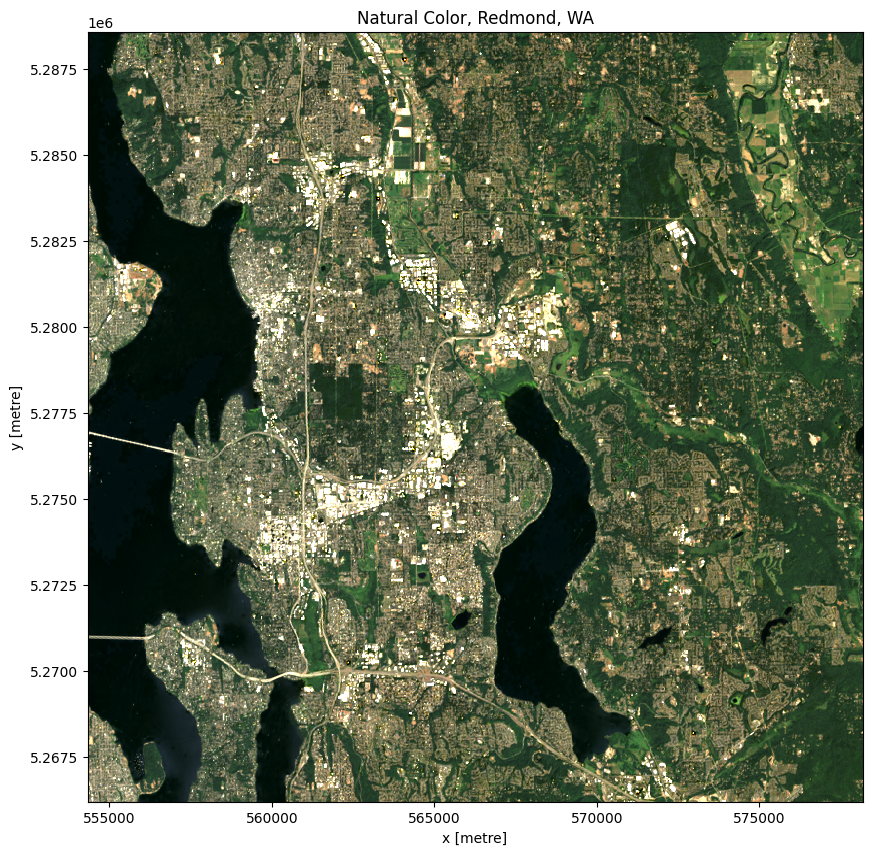

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Redmond, WA")

In [17]:
# Extract the bands from the dataset
print(data)
data_dict = {}
for band in bands_of_interest:
    print(f"{band}: {data[band].values.shape}")
    data_dict[band] = data[band].values

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 747, x: 795)
Coordinates:
  * y            (y) float64 6kB 5.289e+06 5.289e+06 ... 5.266e+06 5.266e+06
  * x            (x) float64 6kB 5.543e+05 5.544e+05 ... 5.781e+05 5.782e+05
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2021-07-25T18:55:39.475647
Data variables:
    nir08        (y, x) uint16 1MB 7187 7216 7237 7251 ... 20871 20917 23931
    red          (y, x) uint16 1MB 7158 7193 7219 7246 ... 8171 9372 8634 8058
    green        (y, x) uint16 1MB 7489 7518 7541 7570 ... 8771 9580 9062 8709
    blue         (y, x) uint16 1MB 7343 7370 7433 7467 ... 8068 8616 8252 8014
nir08: (747, 795)
red: (747, 795)
green: (747, 795)
blue: (747, 795)


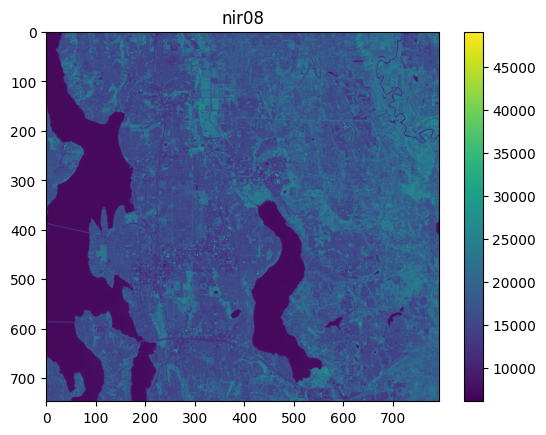

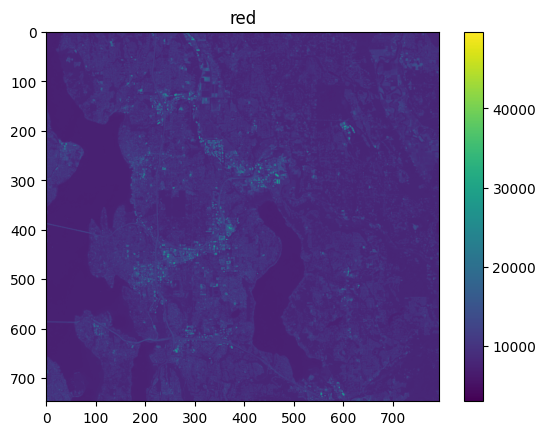

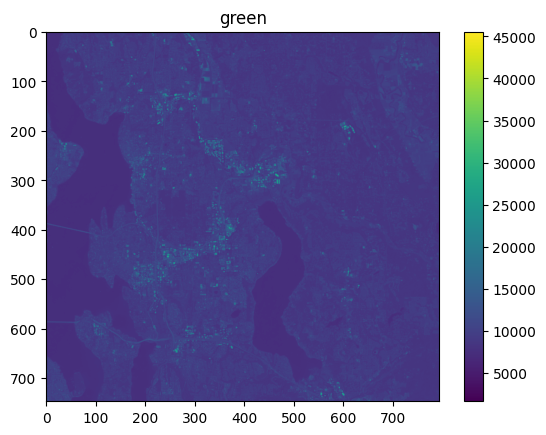

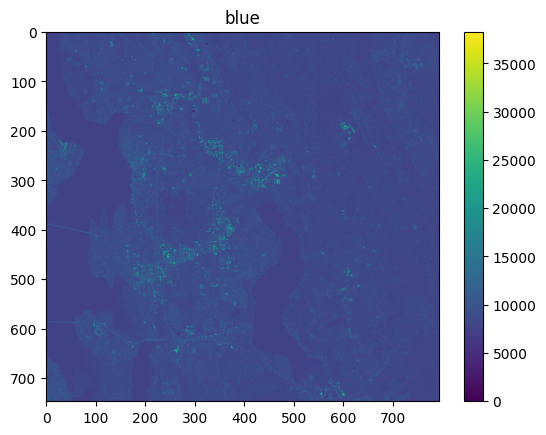

In [19]:
# Plot each band
for band in data_dict.keys():
    plt.figure()
    plt.imshow(data_dict[band])
    plt.colorbar()
    plt.title(band)